<a href="https://colab.research.google.com/github/parkhy0106/HolyMoly/blob/master/Graph(molecular)-neural-network/SDF_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pip install rdkit-pypi

     |████████████████████████████████| 18.6 MB 1.2 MB/s 


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
import os 
path = './drive/MyDrive/235789_Samsung AI Challenge for Scientific Discovery_data.zip (Unzipped Files)/dev_sdf' 
file_list = os.listdir(path) 
print (len(file_list))

71


In [ ]:
cd /content

/content


In [ ]:
!cp -r '/content/drive/MyDrive/235789_Samsung AI Challenge for Scientific Discovery_data.zip (Unzipped Files)' '/content/data'

In [ ]:
!rm -r '/content/data/train_sdf'

In [ ]:
!cp -r '/content/drive/MyDrive/235789_Samsung AI Challenge for Scientific Discovery_data.zip (Unzipped Files)/train_sdf' '/content/data/train_sdf'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from rdkit.Chem.Draw import SimilarityMaps

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from rdkit import DataStructs
import cv2 as cv
from google.colab.patches import cv2_imshow as imshow

In [ ]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('rdkit version :', rdkit.__version__)
print('torch version :', torch.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
opencv version : 4.1.2
rdkit version : 2021.03.4
torch version : 1.9.0+cu102


In [ ]:
train = pd.read_csv('./data/train.csv')
dev = pd.read_csv('./data/dev.csv')

In [ ]:
train.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [ ]:
dev.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,dev_0,O=C1c2ccccc2C2(c3ccccc31)c1ccccc1N(c1ccc(-c3nc...,2.7609,2.7540
1,dev_1,Cc1cccc2c3ccccc3n(-c3ccc(-c4c(-c5ccccc5)c(C#N)...,3.0495,3.0163
2,dev_2,CC1(C)c2ccccc2-c2ccc(-c3c(F)c(F)c(-c4ccc5c(c4)...,2.8314,2.1412
3,dev_3,CC(C)(C)c1ccc2c(c1)B1c3cc(C(C)(C)C)ccc3Oc3cc(-...,3.1813,2.9424
4,dev_4,O=C1c2cc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3)ccc2S...,2.9559,2.7362


In [ ]:
train = pd.concat([train, dev])

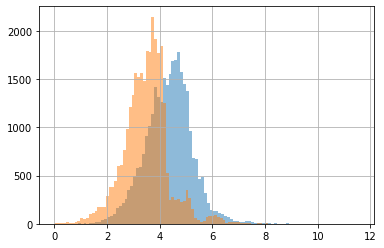

In [ ]:
train['S1_energy(eV)'].hist(bins=100, alpha=0.5)
train['T1_energy(eV)'].hist(bins=100, alpha=0.5)
plt.show()

In [ ]:
!rm -r '/content/data/train_imgs'

rm: cannot remove '/content/data/train_imgs': No such file or directory


In [ ]:
!mkdir '/content/data/train_imgs'

In [ ]:
import gc

In [ ]:
plt.ioff()
for idx, row in tqdm(train.iterrows()):
    if idx <= 29628:
       continue
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        AllChem.ComputeGasteigerCharges(m)
        mol = m
        contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
        fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10,size=(300,300))
        plt.close(fig)
        fig.savefig(f'data/train_imgs/{file}.png',bbox_inches='tight',dpi=39) #dpi 39 = 300x300 pix 1dpi = 0.1299
        del contribs, m, fig
        gc.collect()
plt.ion()

30345it [03:13, 156.69it/s]


In [ ]:
sample_img = cv2.imread('./data/train_imgs/dev_0.png')
plt.imshow(sample_img)
plt.show()

AttributeError: ignored

In [ ]:
device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 25
num_layers = 1
dropout_rate = 0.1
embedding_dim = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = f'./models/best_model.pt'

In [ ]:
class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unique_char = sorted(list(unique_char))
        for i, char in enumerate(unique_char):
            self.txt2idx[char]=i+2
            self.idx2txt[i+2]=char
            
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)

In [ ]:
max_len = train.SMILES.str.len().max()
max_len

In [ ]:
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)

In [ ]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()
imgs = ('./data/train_imgs/'+train.uid+'.png').to_numpy()

In [ ]:
from sklearn.utils import shuffle
imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)

In [ ]:
train_imgs = imgs[:27000]
train_seqs = seqs[:27000]
train_labels = labels[:27000]
val_imgs = imgs[27000:]
val_seqs = seqs[27000:]
val_labels = labels[27000:]

In [ ]:
train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train'):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode=='train':
            self.labels = labels
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        if self.mode == 'train':
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
                'label' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
            }

In [ ]:
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels)
val_dataset = CustomDataset(val_imgs, val_seqs, val_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)

In [ ]:
sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size()

In [ ]:
sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype

In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = models.resnet50(pretrained=vision_pretrain)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers)
        self.final_layer = nn.Linear((max_len+100)*embedding_dim, 2)

    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
        hidden, _ = self.lstm(embedded)
        hidden = hidden.view(hidden.size(0), -1)
        output = nn.ReLU()(self.final_layer(hidden))
        return output

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [ ]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, seq)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
            loss = criterion(output, label)
            
        return loss

In [ ]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

모델 복원

In [ ]:
model = torch.load(save_path)

테스트 데이터 및 제출 양식 로드

In [ ]:
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
for idx, row in tqdm(test.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'./data/test_imgs/{file}.png')

In [ ]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = ('./data/test_imgs/'+test.uid+'.png').to_numpy()

In [ ]:
test_dataset = CustomDataset(imgs=test_imgs, seqs=test_seqs, labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=16)

추론 및 제출

In [ ]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
        gap = output[:, 0] - output[:, 1]
        gap = np.where(gap<0, 0, gap)
        result.extend(list(gap))
        
    return result

In [ ]:
pred = predict(test_dataloader)

In [ ]:
submission['ST1_GAP(eV)'] = pred

In [ ]:
submission

In [ ]:
submission.to_csv('/content/drive/MyDrive/235789_Samsung AI Challenge for Scientific Discovery_data.zip (Unzipped Files)/dacon_baseline.csv', index=False)